In [30]:
import os

import torch
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch import nn
from torch.optim import Adam

from pathlib import Path
from context import LocalLearning as LL
from tqdm.notebook import tqdm
import numpy as np
from matplotlib import pyplot as plt

plt.style.use(['seaborn-paper', "./PRLDoubleCol.mplstyle"])

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
model_path = Path("../data/ICLRrepro/models/khlayer.pty")
if not os.path.exists(model_path.parent):
    os.makedirs(model_path.parent)

In [5]:
model_ps = {
    "in_size": 3 * 32 ** 2,
    "hidden_size": 2000,
    "n": 4.5,
    "p": 3.0,
    "tau_l": 1.0 / 0.02,  # 1 / learning rate
    "k": 2,
    "Delta": 0.4,  # inhibition rate
    "R": 1.0,  # asymptotic weight norm radius
}

In [6]:
# Unsupervised Training Hyperparameters
NO_EPOCHS = 1000
BATCH_SIZE = 1000

In [7]:
model = LL.FKHL3(model_ps, sigma=1.0)
model.to(device=device)

FKHL3(
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [8]:
training_data = LL.Data.LpUnitCIFAR10(
    root="../data/ICLRrepro/CIFAR10", train=True, transform=ToTensor(), p=model_ps["p"]
)

Files already downloaded and verified


In [9]:
dataloader_train = LL.Data.DeviceDataLoader(
    training_data, device=device, batch_size=BATCH_SIZE, num_workers=4, shuffle=True
)

In [10]:
lr = 1.0 / model_ps["tau_l"] 
def learning_rate(epoch: int) -> float:
    return (1.0 - epoch / NO_EPOCHS) * lr

LL.train_unsupervised(
    dataloader_train,
    model,
    device,
    model_path,
    no_epochs=NO_EPOCHS,
    checkpt_period=10,
    learning_rate=learning_rate,
)

Training time [epochs]: 100%|██████████| 1000/1000 [10:30<00:00,  1.58epoch/s]


In [11]:
def MinMaxNorm(x: np.array) -> np.array:
    mi = np.amin(x)
    ma = np.amax(x)
    if np.abs(ma - mi) < 1e-8:
        return np.zeros(x.shape)
    return (x - mi) / (ma - mi)

def display_model_weights(model: LL.FKHL3, Kx=30, Ky=20, fig_width_in=12.9, fig_height_in=10.0, shuffle=True):
    with torch.no_grad():
        # extract weight matrix from model and convert to numpy array
        W = model.W.detach().cpu().clone().numpy()
        W = W.T
        
        if shuffle:  # randomly choose Kx*Ky hidden entries
            W = W[np.random.choice(W.shape[0], Kx*Ky, replace=False)]

    fig, ax = plt.subplots(figsize=(fig_width_in, fig_height_in))
    yy=0
    HM=np.zeros((32*Ky, 32*Kx, 3))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*32:(y+1)*32,x*32:(x+1)*32, :]=MinMaxNorm(W[yy].reshape(32, 32, 3))
            yy += 1

    nc=np.amax(np.absolute(HM))
    im=ax.imshow(HM,cmap='bwr')#,vmin=-nc,vmax=nc)
    #fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    ax.axis('off')
    
    return fig, ax

(<Figure size 928.8x720 with 1 Axes>, <AxesSubplot:>)

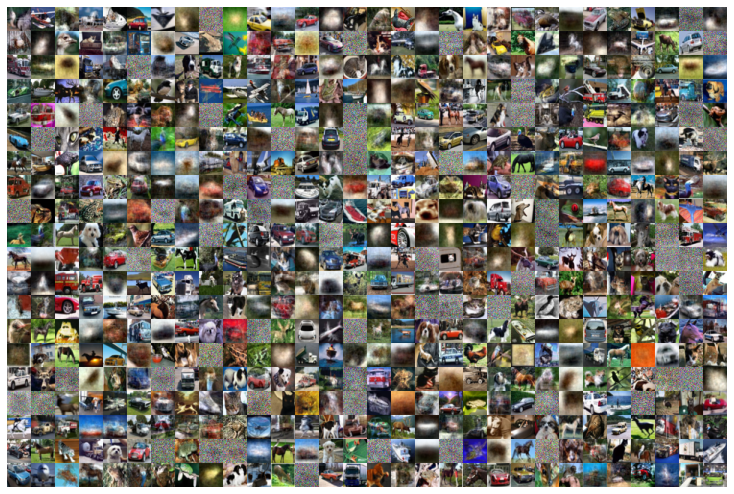

In [12]:
display_model_weights(model)

(<Figure size 928.8x720 with 1 Axes>, <AxesSubplot:>)

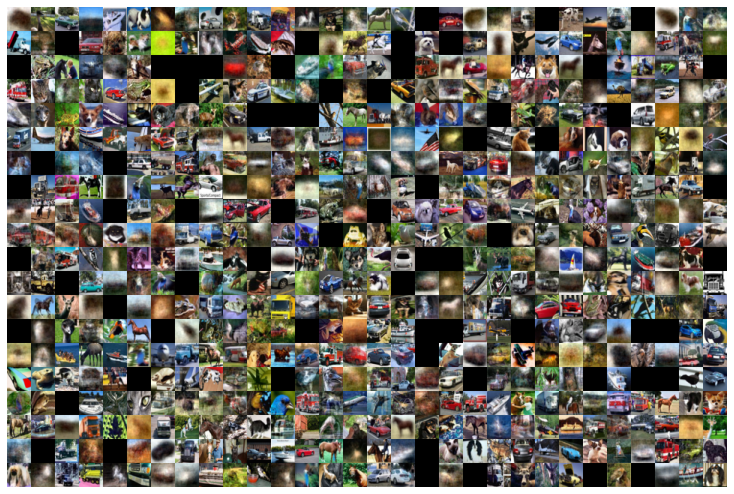

In [15]:
gardener = LL.StatisticGardener()
pruned_model, no_components, cutoff = gardener.prune(model)
display_model_weights(pruned_model)


In [19]:
(torch.abs(torch.norm(model.W, p=model.pSet["p"], dim=0) - 1.0) > 1e-2).sum()

tensor(197, device='cuda:0')

In [20]:
(torch.norm(model.W, p=model.pSet["p"], dim=0) < 1.0).sum()

tensor(164, device='cuda:0')

In [21]:
(model.W.mean(dim=0) < 0).sum()

tensor(10, device='cuda:0')

# Spectrum

In [24]:
test_data = LL.Data.LpUnitCIFAR10(
    root="../data/CIFAR10",
    train=False,
    transform=ToTensor(),
    p=model.pSet["p"],
)

dataloader_test = LL.Data.DeviceDataLoader(
    test_data,
    device=device,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=False,
)

gauss_noise_params = {"mu": 0.0, "sigma": 1.0, "img_width_px": 32, "img_height_px": 32, "img_ch_num": 3} # standard normal Wiener process
gauss_data = LL.Data.GaussianData(gauss_noise_params, train=False)

dataloader_gauss = DataLoader(
    gauss_data,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=False,
)

Files already downloaded and verified


In [34]:
from copy import deepcopy

# save the weight matrix of the model outside of the model
khlayer = deepcopy(pruned_model)
h_sizes = [10, 50, 100, 500, 1000, 1500, 2000]
spectra_cifar = []
spectra_gauss = []
for h_size in h_sizes:
    
    khlayer.to(device)
    khlayer.eval()
    
    with torch.no_grad():
        l_n_trained_cifar = l_n_trained_cifar = LL.cov_spectrum(dataloader_test, khlayer, h_size)
        l_n_trained_cifar = l_n_trained_cifar.detach().cpu().clone().numpy()
        spectra_cifar.append(l_n_trained_cifar)
        
        l_n_trained_gauss = LL.cov_spectrum(dataloader_gauss, khlayer, h_size)
        l_n_trained_gauss = l_n_trained_gauss.detach().cpu().clone().numpy()
        spectra_gauss.append(l_n_trained_gauss)

Calculating covariance spectrum: 100%|██████████| 10/10 [00:00<00:00, 269.46batch/s]


Calculating covariance spectrum: 100%|██████████| 10/10 [00:00<00:00, 10.64batch/s]


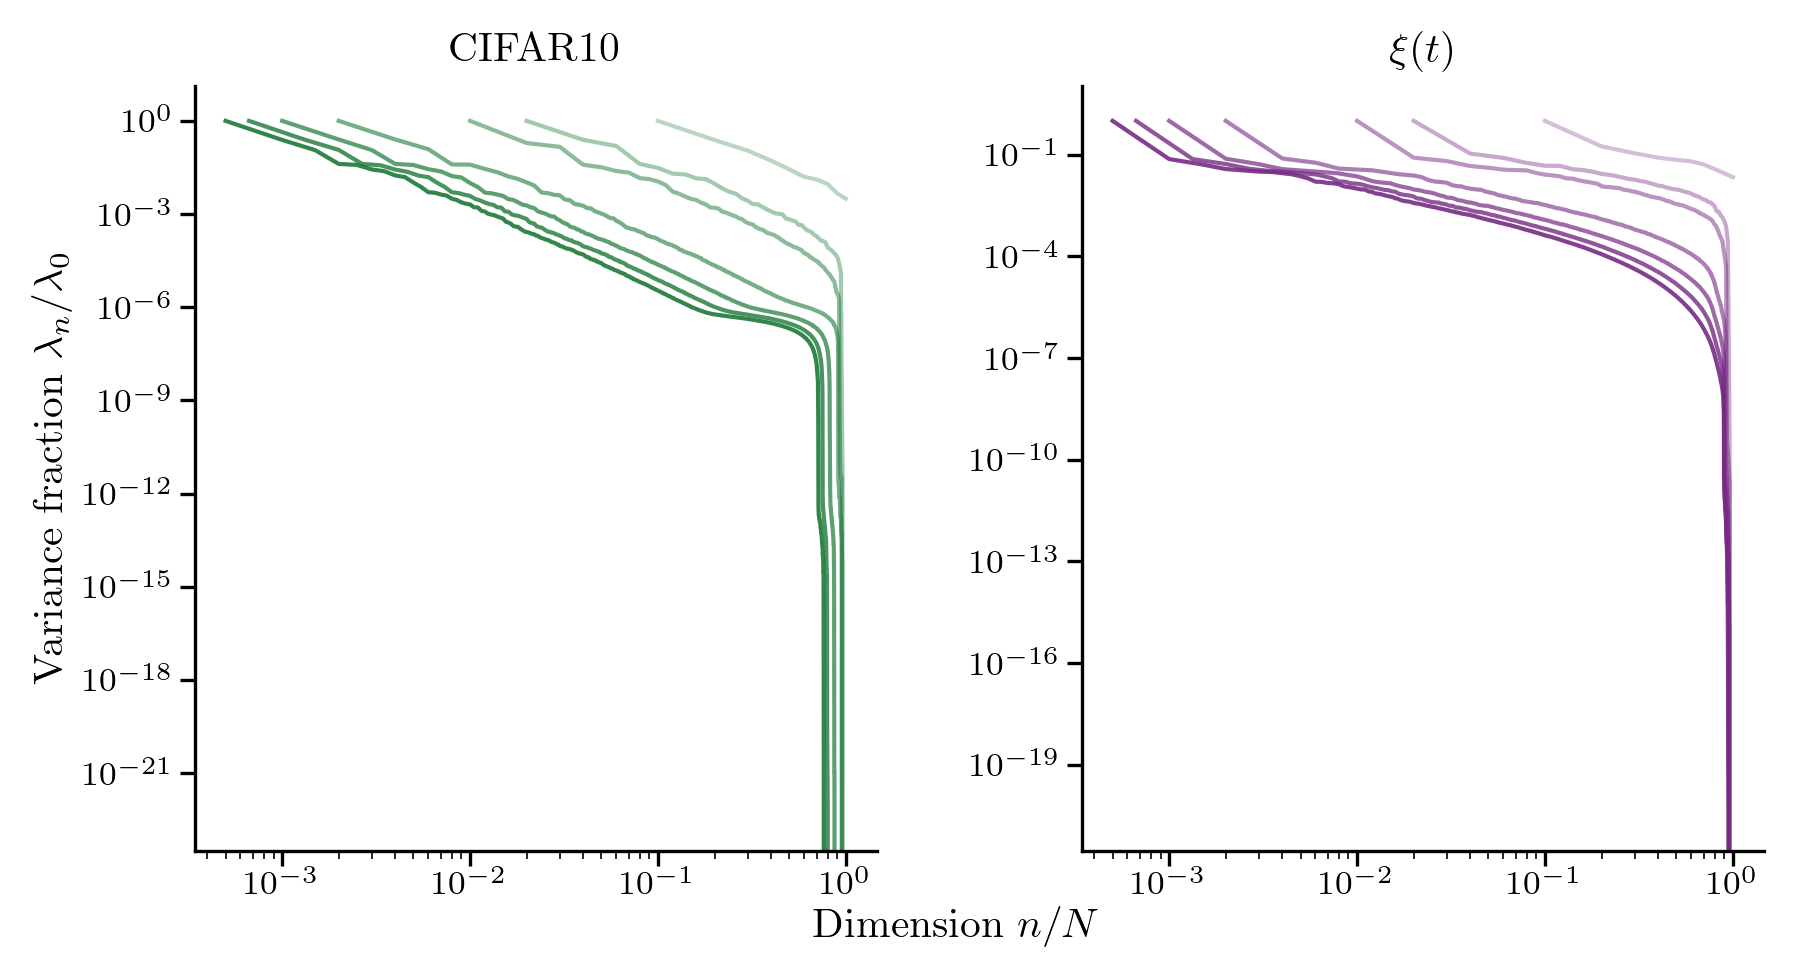

In [35]:
def well_balanced_alpha_gradient(index: int, series_length: int) -> float:
    # well balanced alpha range for line plots: 30%-100%
    return 0.3 + 0.7*index / series_length

fig, axs = plt.subplots(1, 2)
for i, (cifar_spectrum, gauss_spectrum) in enumerate(zip(spectra_cifar, spectra_gauss)):
    cs = cifar_spectrum.copy()
    gs = gauss_spectrum.copy()
    
    # renormalize the x range
    n = np.arange(1, len(gs) + 1)
    n = np.divide(n, float(n[-1]))
    
    # renormalize the spectral data
    cs /= cs[0]
    gs /= gs[0]
    
    alpha = well_balanced_alpha_gradient(i, len(spectra_gauss))
    axs[0].loglog(n, cs, "-", color='#1b7837', alpha=alpha)
    axs[1].loglog(n, gs, "-", color='#762a83', alpha=alpha)

#ax.loglog(n, l_n_trained_gauss)
#fig.title(r"")
fig.text(0.5, 0.04, r"Dimension $n / N$", ha='center')
axs[0].set_ylabel(r"Variance fraction $\lambda_{n} / \lambda_{0}$")
axs[0].set_title(r"CIFAR10")
axs[1].set_title(r"$\xi(t)$")
#fig.savefig(figure_path / Path("UnprunedSpectra_VaryHiddenSize.pdf"))
plt.show()

(array([  1.,   0.,   2.,   0.,   5.,   3.,   9.,   6.,  13.,  13.,   9.,
         21.,  10.,  15.,  16.,  18.,  28.,  32.,  33.,  55.,  73.,  96.,
        141., 176., 201., 192., 164., 178., 139.,  97.,  77.,  44.,  26.,
         16.,   7.,  12.,  16.,  15.,  12.,   7.,   3.,   2.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.]),
 array([-9.        , -8.92405063, -8.84810127, -8.7721519 , -8.69620253,
        -8.62025316, -8.5443038 , -8.46835443, -8.39240506, -8.3164557 ,
        -8.24050633, -8.16455696, -8.08860759, -8.01265823, -7.93670886,
        -7.86075949, -7.78481013, -7.70886076, -7.63291139, -7.55696203,
        -7.48101266, -7.40506329, -7.32911392, -7.25316456, -7.17721519,
        -7.10126582, -7.02531646, -6.94936709, -6.87341772, -6.79746835,
        -6.72151899, -

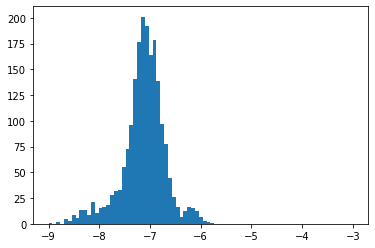

In [16]:
vars = W.var(dim=0).detach().cpu().numpy()
binwidth = 1e-2
plt.hist(np.log(vars), bins=np.linspace(-9, -3, num=80))

In [120]:
gardener = StatisticGardener()
model_pruned, n_components, cutoff = gardener.prune(model)

(<Figure size 928.8x720 with 1 Axes>, <AxesSubplot:>)

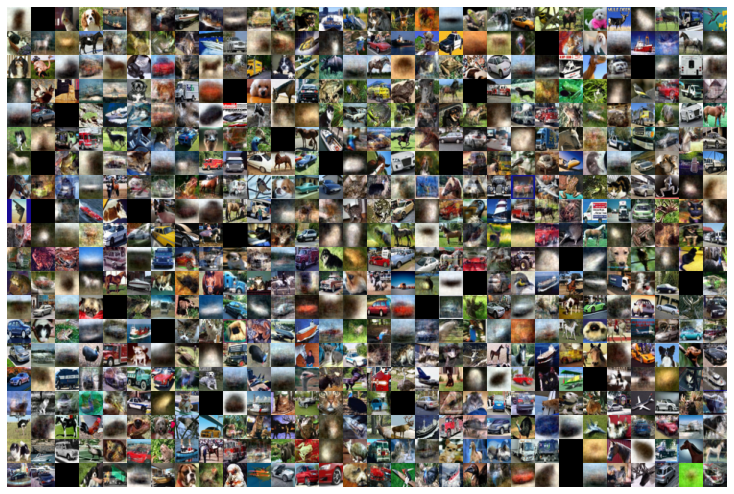

In [121]:
display_model_weights(model_pruned)

In [66]:
idx = np.argmax(gmm_log.means_)
cutoff = gmm_log.means_[idx] - 7*gmm_log.covariances_[idx]
gmm_log.means_[idx] - np.abs(gmm_log.means_[idx] - gmm_log.means_[idx - 1]) / 2.0 

array([-6.45867547])

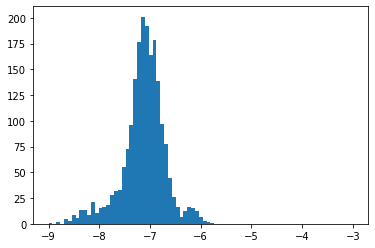

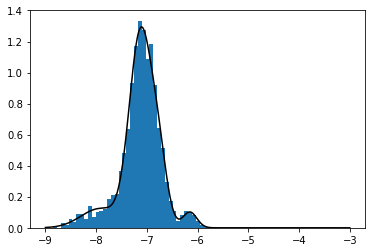

In [23]:
vars = W.var(dim=0).detach().cpu().numpy()
binwidth = 1e-2
plt.hist(np.log(vars), bins=np.linspace(-9, -3, num=80))

def_bins = np.linspace(-9, -3, num=80)
x = np.linspace(-9, -3, num=1000)
x = x.reshape(1000, 1)


fig, ax = plt.subplots(ncols=1, nrows=1) #creating plot axes
(values, bins, _) = ax.hist(log_data,  bins=def_bins, density=True) #Plot histogram
bin_centers = 0.5*(bins[1:] + bins[:-1])


logprob = gmm_log.score_samples(x)
pdf = np.exp(logprob)
ax.plot(x, pdf, label="PDF", color='black') #Plot PDF